In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import coffea.hist as hist
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=RuntimeWarning)

/opt/conda/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
def plothist(x, y, p):

    def gauss_function(x, a, mean, sigma):
        return a*np.exp(-(x - mean)**2/(2 * sigma**2))

    fig, ax = plt.subplots(figsize=(7,7),)

    ax.plot(x, gauss_function(x, *p))
    ax.plot(x, y, 'ok')

from scipy.optimize import curve_fit

def gaussfit(
    x : np.ndarray,
    y : np.ndarray,
    ):

    def gauss_function(x, a, mean, sigma):
        return a*np.exp(-(x - mean)**2/(2 * sigma**2))

    # initial guess
    mean = 1.0
    sigma = np.sqrt(sum((x - mean)**2) / len(x))

    p, pcov = curve_fit(gauss_function, x, y, p0 = [1, mean, sigma])

    # plot fit
    plothist(x, y, p)

    # parameter error
    perr = np.sqrt(np.diag(pcov))

    return (p, perr)

## 512 mini-batches ##

In [3]:
fname = '/work/training_output/20220719-132336_model_config_ranger_lr0.005_batch512/predict_output/pred.root'
events = NanoEventsFactory.from_root(fname, treepath='Events', schemaclass=BaseSchema).events()

In [4]:
events.fields

['target_mass',
 'output',
 'event_no',
 'fj_no',
 'fj_pt',
 'fj_mass',
 'fj_n2b1',
 'fj_eta',
 'fj_phi',
 'fj_msd',
 'fj_npfcands',
 'fj_genjet_sdmass',
 'fj_gen_mass',
 'label_QCD_all',
 'label_H_bb',
 'label_H_cc',
 'label_H_qq',
 'sample_isQCD']

<AxesSubplot:xlabel='$M_{\\rm reco}$/$M_{\\rm target}$', ylabel='Event fraction'>

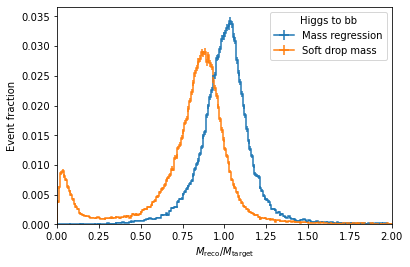

In [5]:
mass = hist.Hist('Event fraction',
                 hist.Cat('sample', 'Higgs to bb'),
                 hist.Bin('mass', '$M_{\\rm reco}$/$M_{\\rm target}$', 200, 0, 2),
                )

mass.fill(sample='Mass regression', mass=events.output[events.label_H_bb==1]/events.target_mass[events.label_H_bb==1])
mass.fill(sample='Soft drop mass', mass=events.fj_msd[events.label_H_bb==1]/events.target_mass[events.label_H_bb==1])

# am not sure this is the correct way to do events fraction
scales = {'Mass regression': 1/len(events.event_no[events.label_H_bb==1]), 'Soft drop mass': 1/len(events.event_no[events.label_H_bb==1])}
mass.scale(scales, axis='sample')

hist.plot1d(mass, overlay='sample')

<AxesSubplot:xlabel='$M_{\\rm reco}$/$M_{\\rm target}$', ylabel='Event fraction'>

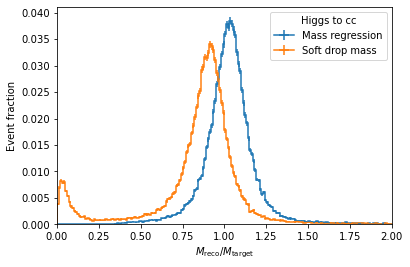

In [6]:
mass = hist.Hist('Event fraction',
                 hist.Cat('sample', 'Higgs to cc'),
                 hist.Bin('mass', '$M_{\\rm reco}$/$M_{\\rm target}$', 200, 0, 2),
                )

mass.fill(sample='Mass regression', mass=events.output[events.label_H_cc==1]/events.target_mass[events.label_H_cc==1])
mass.fill(sample='Soft drop mass', mass=events.fj_msd[events.label_H_cc==1]/events.target_mass[events.label_H_cc==1])

# am not sure this is the correct way to do events fraction
scales = {'Mass regression': 1/len(events.event_no[events.label_H_bb==1]), 'Soft drop mass': 1/len(events.event_no[events.label_H_bb==1])}
mass.scale(scales, axis='sample')

hist.plot1d(mass, overlay='sample')

<AxesSubplot:xlabel='$M_{\\rm reco}$/$M_{\\rm target}$', ylabel='Event fraction'>

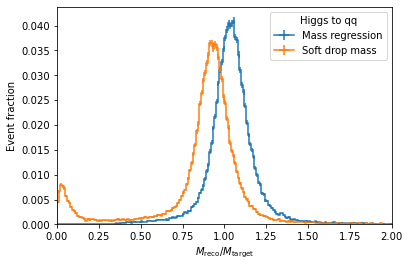

In [11]:
mass = hist.Hist('Event fraction',
                 hist.Cat('sample', 'Higgs to qq'),
                 hist.Bin('mass', '$M_{\\rm reco}$/$M_{\\rm target}$', 200, 0, 2),
                )

mass.fill(sample='Mass regression', mass=events.output[events.label_H_qq==1]/events.target_mass[events.label_H_qq==1])
mass.fill(sample='Soft drop mass', mass=events.fj_msd[events.label_H_qq==1]/events.target_mass[events.label_H_qq==1])

# am not sure this is the correct way to do events fraction
scales = {'Mass regression': 1/len(events.event_no[events.label_H_qq==1]), 
          'Soft drop mass': 1/len(events.event_no[events.label_H_qq==1])}
mass.scale(scales, axis='sample')

hist.plot1d(mass, overlay='sample')

<AxesSubplot:xlabel='$M_{\\rm reco}$/$M_{\\rm target}$', ylabel='Event fraction'>

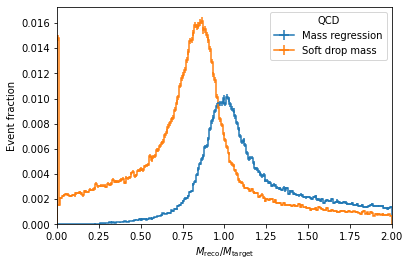

In [7]:
mass = hist.Hist('Event fraction',
                 hist.Cat('sample', 'QCD'),
                 hist.Bin('mass', '$M_{\\rm reco}$/$M_{\\rm target}$', 200, 0, 2),
                )

mass.fill(sample='Mass regression', mass=events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1)])
mass.fill(sample='Soft drop mass', mass=events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1)])

# am not sure this is the correct way to do events fraction
scales = {'Mass regression': 1/len(events.event_no[(events.sample_isQCD==1) & (events.label_QCD_all==1)]), 'Soft drop mass': 1/len(events.event_no[(events.sample_isQCD==1) & (events.label_QCD_all==1)])}
mass.scale(scales, axis='sample')

hist.plot1d(mass, overlay='sample')

In [5]:
# function for computing mass resolution
def getEffSigma(theHist, wmin=0.2, wmax=180, epsilon=0.01):

    point = wmin
    weight = 0.0
    points = []
    # number of all jets
    thesum = theHist.sum("sample", "mass").values()[()]

    # number of jets in each bin
    values = theHist.sum("sample").values()[()]

    # bin centers
    centers = theHist.to_hist().axes['mass'].centers

    # fill list of bin centers and the integral up to those points
    for i, value in enumerate(values):
        weight += value
        points.append([centers[i], weight / thesum])

    low = wmin
    high = wmax

    # loop over all possible bin combninations and find the one
    # with smallest width and ~68% of all jets
    width = wmax - wmin
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
#             print(wy)
            if abs(wy - 0.683) < epsilon:
#                 print("here")
                wx = points[j][0] - points[i][0]
#                 print(wx)
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    # print(points[j][0], points[i][0], wy, wx)
                    width = wx
    print(low, high)
    return 0.5 * (high - low)

targetmasses = np.array([60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180])
# for holding effective sigma values
Hbbr = np.zeros(len(targetmasses))
Hbbsd = np.zeros(len(targetmasses))
Hccr = np.zeros(len(targetmasses))
Hccsd = np.zeros(len(targetmasses))
Hqqr = np.zeros(len(targetmasses))
Hqqsd = np.zeros(len(targetmasses))
qcdr = np.zeros(len(targetmasses))
qcdsd = np.zeros(len(targetmasses))

# MPVs for mass ratio (divided by target mass)
Hbbrm = np.zeros(len(targetmasses))
Hbbsdm = np.zeros(len(targetmasses))
Hccrm = np.zeros(len(targetmasses))
Hccsdm = np.zeros(len(targetmasses))
Hqqrm = np.zeros(len(targetmasses))
Hqqsdm = np.zeros(len(targetmasses))
qcdrm = np.zeros(len(targetmasses))
qcdsdm = np.zeros(len(targetmasses))

for i in range(len(targetmasses)):
    targetmass = targetmasses[i]
    
    # hbbr
    hbbrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hbbrhist.fill(sample='H->bb (regression)', 
                  mass=events.output[(events.fj_gen_mass==targetmass) & (events.label_H_bb==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_bb==1)])

    Hbbr[i] = getEffSigma(hbbrhist)

    values = hbbrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hbbrhist.to_hist().axes['mass'].centers
    Hbbrm[i] = centers[index]
    
    # hbbsd
    hbbsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hbbsdhist.fill(sample='H->bb (soft drop)', 
                  mass=events.fj_msd[(events.fj_gen_mass==targetmass) & (events.label_H_bb==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_bb==1)])

    Hbbsd[i] = getEffSigma(hbbsdhist)
    
    values = hbbsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hbbsdhist.to_hist().axes['mass'].centers
    Hbbsdm[i] = centers[index]
    
    # hccr
    hccrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hccrhist.fill(sample='H->cc (regression)', 
                  mass=events.output[(events.fj_gen_mass==targetmass) & (events.label_H_cc==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_cc==1)])

    Hccr[i] = getEffSigma(hccrhist)
    
    values = hccrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hccrhist.to_hist().axes['mass'].centers
    Hccrm[i] = centers[index]
    
    # hccsd
    hccsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hccsdhist.fill(sample='H->cc (soft drop)', 
                  mass=events.fj_msd[(events.fj_gen_mass==targetmass) & (events.label_H_cc==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_cc==1)])

    Hccsd[i] = getEffSigma(hccsdhist)
    
    values = hccsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hccsdhist.to_hist().axes['mass'].centers
    Hccsdm[i] = centers[index]
    
    # hqqr
    hqqrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hqqrhist.fill(sample='H->qq (regression)', 
                  mass=events.output[(events.fj_gen_mass==targetmass) & (events.label_H_qq==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_qq==1)])

    Hqqr[i] = getEffSigma(hqqrhist)
    
    values = hqqrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hqqrhist.to_hist().axes['mass'].centers
    Hqqrm[i] = centers[index]
    
    # hqqsd
    hqqsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hqqsdhist.fill(sample='H->qq (soft drop)', 
                  mass=events.fj_msd[(events.fj_gen_mass==targetmass) & (events.label_H_qq==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_qq==1)])

    Hqqsd[i] = getEffSigma(hqqsdhist)
    
    values = hqqsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hqqsdhist.to_hist().axes['mass'].centers
    Hqqsdm[i] = centers[index]
    
    #qcdr
    qcdrhist = hist.Hist('Events',
                         hist.Cat('sample', 'sample name'),
                         hist.Bin('mass', 'Mass', 200, 0, 2),
                        )

    qcdrhist.fill(sample='QCD (regression)', 
                  mass=events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_genjet_sdmass-targetmass) < 10) & ((events.fj_genjet_sdmass-targetmass) >= 0)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_genjet_sdmass-targetmass) < 10) & ((events.fj_genjet_sdmass-targetmass) >= 0)])
    
    qcdr[i] = getEffSigma(qcdrhist)
    
    values = qcdrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = qcdrhist.to_hist().axes['mass'].centers
    qcdrm[i] = centers[index]
    
    #qcdsd
    qcdsdhist = hist.Hist('Events',
                         hist.Cat('sample', 'sample name'),
                         hist.Bin('mass', 'Mass', 200, 0, 2),
                        )

    qcdsdhist.fill(sample='QCD (soft drop)', 
                  mass=events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_genjet_sdmass-targetmass) < 10) & ((events.fj_genjet_sdmass-targetmass) >= 0)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_genjet_sdmass-targetmass) < 10) & ((events.fj_genjet_sdmass-targetmass) >= 0)])
    
    qcdsd[i] = getEffSigma(qcdsdhist)
    
    values = qcdsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = qcdsdhist.to_hist().axes['mass'].centers
    qcdsdm[i] = centers[index]
    
    

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


0.995 1.155
0.595 1.025
0.995 1.155
0.665 1.045
0.995 1.155
0.725 1.075
0.945 1.175
0.685 1.005
0.865 1.095
0.605 1.005
0.905 1.125
0.695 1.035
0.905 1.125
0.765 1.075
0.875 1.125
0.665 0.975
0.815 1.105
0.645 1.005
0.885 1.145
0.705 1.035
0.905 1.155
0.755 1.065
0.855 1.125
0.685 0.975
0.855 1.155
0.675 1.025
0.885 1.145
0.725 1.035
0.915 1.155
0.765 1.045
0.845 1.105
0.705 0.975
0.845 1.135
0.675 1.005
0.905 1.155
0.735 1.035
0.955 1.175
0.795 1.055
0.845 1.095
0.725 0.985
0.865 1.135
0.705 1.015
0.915 1.145
0.745 1.025
0.925 1.135
0.785 1.045
0.865 1.095
0.705 0.955
0.875 1.125
0.695 1.005
0.915 1.135
0.765 1.035
0.915 1.115
0.805 1.045
0.865 1.085
0.745 0.975
0.875 1.115
0.705 1.005
0.895 1.105
0.735 1.015
0.925 1.115
0.805 1.045
0.855 1.065
0.735 0.965
0.855 1.085
0.705 1.005
0.905 1.095
0.785 1.035
0.915 1.095
0.805 1.035
0.865 1.055
0.755 0.965
0.875 1.085
0.715 1.005
0.895 1.085
0.755 1.015
0.905 1.075
0.795 1.025
0.875 1.055
0.745 0.955
0.845 1.055
0.735 1.005
0.875 1.065
0.77

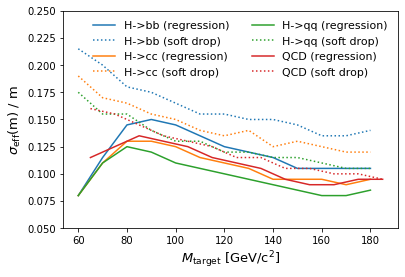

In [8]:
plt.plot(targetmasses, Hbbr, label='H->bb (regression)', c='C0')
plt.plot(targetmasses, Hbbsd, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetmasses, Hccr, label='H->cc (regression)', c='C1')
plt.plot(targetmasses, Hccsd, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetmasses, Hqqr, label='H->qq (regression)', c='C2')
plt.plot(targetmasses, Hqqsd, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetmasses+5, qcdr, label='QCD (regression)', c='C3')
plt.plot(targetmasses+5, qcdsd, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('$M_{\\rm target}$ [GeV/${\\rm c}^2$]', fontsize=13)
plt.ylabel('$\sigma_{\\rm eff}$(m) / m', fontsize=13)
plt.ylim([0.05, 0.25])
plt.show()

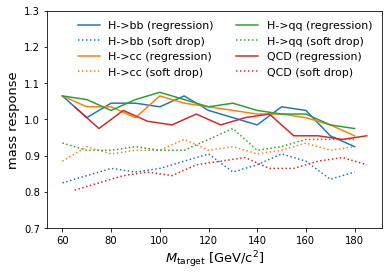

In [8]:
plt.plot(targetmasses, Hbbrm, label='H->bb (regression)', c='C0')
plt.plot(targetmasses, Hbbsdm, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetmasses, Hccrm, label='H->cc (regression)', c='C1')
plt.plot(targetmasses, Hccsdm, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetmasses, Hqqrm, label='H->qq (regression)', c='C2')
plt.plot(targetmasses, Hqqsdm, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetmasses+5, qcdrm, label='QCD (regression)', c='C3')
plt.plot(targetmasses+5, qcdsdm, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('$M_{\\rm target}$ [GeV/${\\rm c}^2$]', fontsize=13)
plt.ylabel('mass response', fontsize=13)
plt.ylim([0.7, 1.3])
plt.show()

In [5]:
# function for computing mass resolution
def getEffSigma(theHist, wmin=0.2, wmax=1.8, epsilon=0.01):

    point = wmin
    weight = 0.0
    points = []
    # number of all jets
    thesum = theHist.sum("sample", "mass").values()[()]

    # number of jets in each bin
    values = theHist.sum("sample").values()[()]

    # bin centers
    centers = theHist.to_hist().axes['mass'].centers

    # fill list of bin centers and the integral up to those points
    for i, value in enumerate(values):
        weight += value
        points.append([centers[i], weight / thesum])

    low = wmin
    high = wmax

    # loop over all possible bin combninations and find the one
    # with smallest width and ~68% of all jets
    width = wmax - wmin
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
#             print(wy)
            if abs(wy - 0.683) < epsilon:
#                 print("here")
                wx = points[j][0] - points[i][0]
#                 print(wx)
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    # print(points[j][0], points[i][0], wy, wx)
                    width = wx
    print(low, high)
    return 0.5 * (high - low)

targetpts = np.linspace(200, 2500, 47)
# for holding effective sigma values
Hbbr = np.zeros(len(targetpts))
Hbbsd = np.zeros(len(targetpts))
Hccr = np.zeros(len(targetpts))
Hccsd = np.zeros(len(targetpts))
Hqqr = np.zeros(len(targetpts))
Hqqsd = np.zeros(len(targetpts))
qcdr = np.zeros(len(targetpts))
qcdsd = np.zeros(len(targetpts))

# MPVs for mass ratio (divided by target mass)
Hbbrm = np.zeros(len(targetpts))
Hbbsdm = np.zeros(len(targetpts))
Hccrm = np.zeros(len(targetpts))
Hccsdm = np.zeros(len(targetpts))
Hqqrm = np.zeros(len(targetpts))
Hqqsdm = np.zeros(len(targetpts))
qcdrm = np.zeros(len(targetpts))
qcdsdm = np.zeros(len(targetpts))

for i in range(len(targetpts)):
    targetpt = targetpts[i]
    
    # hbbr
    hbbrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hbbrhist.fill(sample='H->bb (regression)', 
                  mass=events.output[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_bb==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_bb==1)])

    Hbbr[i] = getEffSigma(hbbrhist)
    
    values = hbbrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hbbrhist.to_hist().axes['mass'].centers
    Hbbrm[i] = centers[index]
    
    # hbbsd
    hbbsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hbbsdhist.fill(sample='H->bb (soft drop)', 
                  mass=events.fj_msd[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_bb==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_bb==1)])

    Hbbsd[i] = getEffSigma(hbbsdhist)
    
    values = hbbsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hbbsdhist.to_hist().axes['mass'].centers
    Hbbsdm[i] = centers[index]
    
    # hccr
    hccrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hccrhist.fill(sample='H->cc (regression)', 
                  mass=events.output[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_cc==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_cc==1)])

    Hccr[i] = getEffSigma(hccrhist)
    
    values = hccrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hccrhist.to_hist().axes['mass'].centers
    Hccrm[i] = centers[index]
    
    # hccsd
    hccsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hccsdhist.fill(sample='H->cc (soft drop)', 
                  mass=events.fj_msd[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_cc==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_cc==1)])

    Hccsd[i] = getEffSigma(hccsdhist)
    
    values = hccsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hccsdhist.to_hist().axes['mass'].centers
    Hccsdm[i] = centers[index]
    
    # hqqr
    hqqrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hqqrhist.fill(sample='H->qq (regression)', 
                  mass=events.output[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_qq==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_qq==1)])

    Hqqr[i] = getEffSigma(hqqrhist)
    
    values = hqqrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hqqrhist.to_hist().axes['mass'].centers
    Hqqrm[i] = centers[index]
    
    # hqqsd
    hqqsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hqqsdhist.fill(sample='H->qq (soft drop)', 
                  mass=events.fj_msd[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_qq==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_qq==1)])

    Hqqsd[i] = getEffSigma(hqqsdhist)
    
    values = hqqsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hqqsdhist.to_hist().axes['mass'].centers
    Hqqsdm[i] = centers[index]
    
    #qcdr
    qcdrhist = hist.Hist('Events',
                         hist.Cat('sample', 'sample name'),
                         hist.Bin('mass', 'Mass', 200, 0, 2),
                        )

    qcdrhist.fill(sample='QCD (regression)', 
                  mass=events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0)])
    
    qcdr[i] = getEffSigma(qcdrhist)
    
    values = qcdrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = qcdrhist.to_hist().axes['mass'].centers
    qcdrm[i] = centers[index]
    
    #qcdsd
    qcdsdhist = hist.Hist('Events',
                         hist.Cat('sample', 'sample name'),
                         hist.Bin('mass', 'Mass', 200, 0, 2),
                        )

    qcdsdhist.fill(sample='QCD (soft drop)', 
                  mass=events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0)])
    
    qcdsd[i] = getEffSigma(qcdsdhist)
    
    values = qcdsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = qcdsdhist.to_hist().axes['mass'].centers
    qcdsdm[i] = centers[index]

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


0.815 1.185
0.555 0.945
0.855 1.195
0.615 1.005
0.925 1.255
0.675 1.045
0.785 1.385
0.415 1.015
0.835 1.165
0.635 1.005
0.865 1.175
0.675 1.025
0.905 1.185
0.725 1.055
0.815 1.395
0.435 1.015
0.835 1.135
0.665 1.005
0.875 1.145
0.695 1.015
0.905 1.155
0.775 1.065
0.825 1.385
0.415 1.025
0.855 1.125
0.695 1.015
0.905 1.145
0.745 1.035
0.905 1.135
0.765 1.035
0.795 1.355
0.415 1.035
0.865 1.115
0.685 0.995
0.895 1.125
0.745 1.025
0.915 1.125
0.795 1.045
0.785 1.335
0.405 1.035
0.855 1.095
0.705 1.005
0.885 1.105
0.755 1.025
0.915 1.115
0.785 1.035
0.755 1.305
0.445 1.075
0.865 1.095
0.735 1.015
0.885 1.095
0.765 1.025
0.925 1.115
0.795 1.035
0.745 1.295
0.465 1.105
0.875 1.095
0.715 1.005
0.905 1.105
0.785 1.035
0.905 1.095
0.825 1.055
0.745 1.285
0.415 1.045
0.885 1.095
0.755 1.035
0.905 1.095
0.775 1.025
0.905 1.095
0.815 1.045
0.735 1.265
0.385 1.035
0.895 1.105
0.735 1.025
0.915 1.105
0.785 1.035
0.945 1.125
0.815 1.055
0.785 1.315
0.395 1.075
0.885 1.105
0.735 1.045
0.935 1.125
0.78

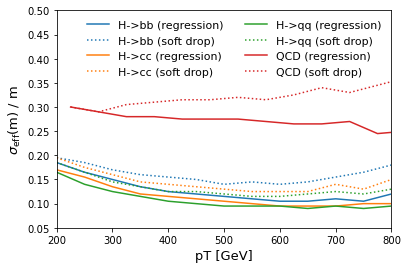

In [29]:
plt.plot(targetpts, Hbbr, label='H->bb (regression)', c='C0')
plt.plot(targetpts, Hbbsd, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetpts, Hccr, label='H->cc (regression)', c='C1')
plt.plot(targetpts, Hccsd, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetpts, Hqqr, label='H->qq (regression)', c='C2')
plt.plot(targetpts, Hqqsd, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetpts+25, qcdr, label='QCD (regression)', c='C3')
plt.plot(targetpts+25, qcdsd, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('pT [GeV]', fontsize=13)
plt.ylabel('$\sigma_{\\rm eff}$(m) / m', fontsize=13)
plt.ylim([0.05, 0.5])
plt.xlim([200, 800])
plt.show()

In [30]:
Hbbre = np.zeros(len(targetpts))
Hbbsde = np.zeros(len(targetpts))
Hccre = np.zeros(len(targetpts))
Hccsde = np.zeros(len(targetpts))
Hqqre = np.zeros(len(targetpts))
Hqqsde = np.zeros(len(targetpts))
qcdre = np.zeros(len(targetpts))
qcdsde = np.zeros(len(targetpts))

for i in range(len(targetpts)):
    # hbbr
    sigma_eff = Hbbr[i]
    MPV = Hbbrm[i]

    jets = len(events.output[(events.label_H_bb==1) & ((events.output/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.output/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hbbre[i]=jets/len(events.output[events.label_H_bb==1])
    
    # hbbsd
    sigma_eff = Hbbsd[i]
    MPV = Hbbsdm[i]

    jets = len(events.fj_msd[(events.label_H_bb==1) & ((events.fj_msd/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.fj_msd/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hbbsde[i]=jets/len(events.fj_msd[events.label_H_bb==1])
    
    # hccr
    sigma_eff = Hccr[i]
    MPV = Hccrm[i]

    jets = len(events.output[(events.label_H_cc==1) & ((events.output/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.output/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hccre[i]=jets/len(events.output[events.label_H_cc==1])
    
    # hccsd
    sigma_eff = Hccsd[i]
    MPV = Hccsdm[i]

    jets = len(events.fj_msd[(events.label_H_cc==1) & ((events.fj_msd/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.fj_msd/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hccsde[i]=jets/len(events.fj_msd[events.label_H_cc==1])
    
    # hqqr
    sigma_eff = Hqqr[i]
    MPV = Hqqrm[i]

    jets = len(events.output[(events.label_H_qq==1) & ((events.output/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.output/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hqqre[i]=jets/len(events.output[events.label_H_qq==1])
    
    # hqqsd
    sigma_eff = Hqqsd[i]
    MPV = Hqqsdm[i]

    jets = len(events.fj_msd[(events.label_H_qq==1) & ((events.fj_msd/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.fj_msd/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hqqsde[i]=jets/len(events.fj_msd[events.label_H_qq==1])
    
    # qcdr
    sigma_eff = qcdr[i]
    MPV = qcdrm[i]

    jets = len(events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.output/events.fj_genjet_sdmass) > (MPV - 2 * sigma_eff)) & ((events.output/events.fj_genjet_sdmass) < (MPV + 2 * sigma_eff))])
    qcdre[i]=jets/len(events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1)])
    
    # qcdsd
    sigma_eff = qcdsd[i]
    MPV = qcdsdm[i]

    jets = len(events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_msd/events.fj_genjet_sdmass) > (MPV - 2 * sigma_eff)) & ((events.fj_msd/events.fj_genjet_sdmass) < (MPV + 2 * sigma_eff))])
    qcdsde[i]=jets/len(events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1)])


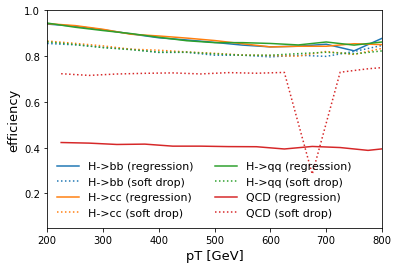

In [31]:
plt.plot(targetpts, Hbbre, label='H->bb (regression)', c='C0')
plt.plot(targetpts, Hbbsde, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetpts, Hccre, label='H->cc (regression)', c='C1')
plt.plot(targetpts, Hccsde, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetpts, Hqqre, label='H->qq (regression)', c='C2')
plt.plot(targetpts, Hqqsde, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetpts+25, qcdre, label='QCD (regression)', c='C3')
plt.plot(targetpts+25, qcdsde, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('pT [GeV]', fontsize=13)
plt.ylabel('efficiency', fontsize=13)
plt.ylim([0.05, 1])
plt.xlim([200, 800])
plt.show()

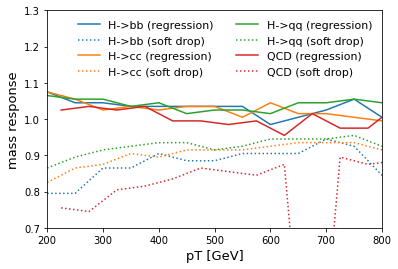

In [9]:
plt.plot(targetpts, Hbbrm, label='H->bb (regression)', c='C0')
plt.plot(targetpts, Hbbsdm, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetpts, Hccrm, label='H->cc (regression)', c='C1')
plt.plot(targetpts, Hccsdm, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetpts, Hqqrm, label='H->qq (regression)', c='C2')
plt.plot(targetpts, Hqqsdm, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetpts+25, qcdrm, label='QCD (regression)', c='C3')
plt.plot(targetpts+25, qcdsdm, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('pT [GeV]', fontsize=13)
plt.ylabel('mass response', fontsize=13)
plt.ylim([0.7, 1.3])
plt.xlim([200, 800])
plt.show()

## 1024 minibatches ##

In [9]:
fname = '/work/training_output/20220720-143552_model_config_ranger_lr0.005_batch1024/predict_output/pred.root'
events = NanoEventsFactory.from_root(fname, treepath='Events', schemaclass=BaseSchema).events()

<AxesSubplot:xlabel='$M_{\\rm reco}$/$M_{\\rm target}$', ylabel='Event fraction'>

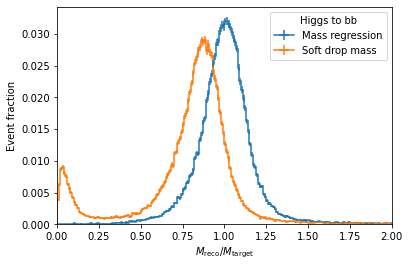

In [10]:
mass = hist.Hist('Event fraction',
                 hist.Cat('sample', 'Higgs to bb'),
                 hist.Bin('mass', '$M_{\\rm reco}$/$M_{\\rm target}$', 200, 0, 2),
                )

mass.fill(sample='Mass regression', mass=events.output[events.label_H_bb==1]/events.target_mass[events.label_H_bb==1])
mass.fill(sample='Soft drop mass', mass=events.fj_msd[events.label_H_bb==1]/events.target_mass[events.label_H_bb==1])

# am not sure this is the correct way to do events fraction
scales = {'Mass regression': 1/len(events.event_no[events.label_H_bb==1]), 'Soft drop mass': 1/len(events.event_no[events.label_H_bb==1])}
mass.scale(scales, axis='sample')

hist.plot1d(mass, overlay='sample')

<AxesSubplot:xlabel='$M_{\\rm reco}$/$M_{\\rm target}$', ylabel='Event fraction'>

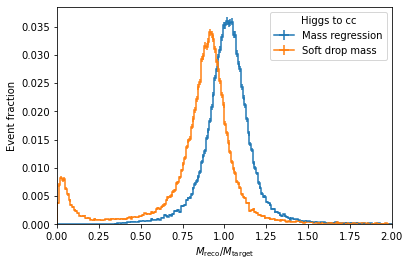

In [11]:
mass = hist.Hist('Event fraction',
                 hist.Cat('sample', 'Higgs to cc'),
                 hist.Bin('mass', '$M_{\\rm reco}$/$M_{\\rm target}$', 200, 0, 2),
                )

mass.fill(sample='Mass regression', mass=events.output[events.label_H_cc==1]/events.target_mass[events.label_H_cc==1])
mass.fill(sample='Soft drop mass', mass=events.fj_msd[events.label_H_cc==1]/events.target_mass[events.label_H_cc==1])

# am not sure this is the correct way to do events fraction
scales = {'Mass regression': 1/len(events.event_no[events.label_H_bb==1]), 'Soft drop mass': 1/len(events.event_no[events.label_H_bb==1])}
mass.scale(scales, axis='sample')

hist.plot1d(mass, overlay='sample')

<AxesSubplot:xlabel='$M_{\\rm reco}$/$M_{\\rm target}$', ylabel='Event fraction'>

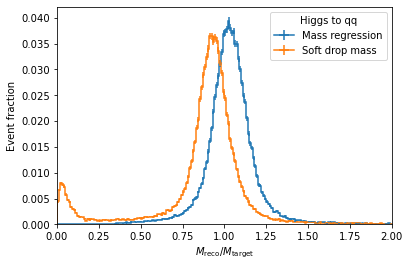

In [12]:
mass = hist.Hist('Event fraction',
                 hist.Cat('sample', 'Higgs to qq'),
                 hist.Bin('mass', '$M_{\\rm reco}$/$M_{\\rm target}$', 200, 0, 2),
                )

mass.fill(sample='Mass regression', mass=events.output[events.label_H_qq==1]/events.target_mass[events.label_H_qq==1])
mass.fill(sample='Soft drop mass', mass=events.fj_msd[events.label_H_qq==1]/events.target_mass[events.label_H_qq==1])

# am not sure this is the correct way to do events fraction
scales = {'Mass regression': 1/len(events.event_no[events.label_H_qq==1]), 
          'Soft drop mass': 1/len(events.event_no[events.label_H_qq==1])}
mass.scale(scales, axis='sample')

hist.plot1d(mass, overlay='sample')

<AxesSubplot:xlabel='$M_{\\rm reco}$/$M_{\\rm target}$', ylabel='Event fraction'>

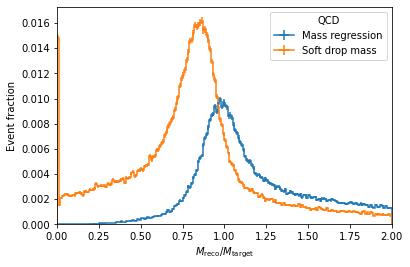

In [13]:
mass = hist.Hist('Event fraction',
                 hist.Cat('sample', 'QCD'),
                 hist.Bin('mass', '$M_{\\rm reco}$/$M_{\\rm target}$', 200, 0, 2),
                )

mass.fill(sample='Mass regression', mass=events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1)])
mass.fill(sample='Soft drop mass', mass=events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1)])

# am not sure this is the correct way to do events fraction
scales = {'Mass regression': 1/len(events.event_no[(events.sample_isQCD==1) & (events.label_QCD_all==1)]), 'Soft drop mass': 1/len(events.event_no[(events.sample_isQCD==1) & (events.label_QCD_all==1)])}
mass.scale(scales, axis='sample')

hist.plot1d(mass, overlay='sample')

In [10]:
# function for computing mass resolution
def getEffSigma(theHist, wmin=0.2, wmax=180, epsilon=0.01):

    point = wmin
    weight = 0.0
    points = []
    # number of all jets
    thesum = theHist.sum("sample", "mass").values()[()]

    # number of jets in each bin
    values = theHist.sum("sample").values()[()]

    # bin centers
    centers = theHist.to_hist().axes['mass'].centers

    # fill list of bin centers and the integral up to those points
    for i, value in enumerate(values):
        weight += value
        points.append([centers[i], weight / thesum])

    low = wmin
    high = wmax

    # loop over all possible bin combninations and find the one
    # with smallest width and ~68% of all jets
    width = wmax - wmin
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
#             print(wy)
            if abs(wy - 0.683) < epsilon:
#                 print("here")
                wx = points[j][0] - points[i][0]
#                 print(wx)
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    # print(points[j][0], points[i][0], wy, wx)
                    width = wx
    print(low, high)
    return 0.5 * (high - low)

targetmasses = np.array([60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180])
# for holding effective sigma values
Hbbr = np.zeros(len(targetmasses))
Hbbsd = np.zeros(len(targetmasses))
Hccr = np.zeros(len(targetmasses))
Hccsd = np.zeros(len(targetmasses))
Hqqr = np.zeros(len(targetmasses))
Hqqsd = np.zeros(len(targetmasses))
qcdr = np.zeros(len(targetmasses))
qcdsd = np.zeros(len(targetmasses))

# MPVs for mass ratio (divided by target mass)
Hbbrm = np.zeros(len(targetmasses))
Hbbsdm = np.zeros(len(targetmasses))
Hccrm = np.zeros(len(targetmasses))
Hccsdm = np.zeros(len(targetmasses))
Hqqrm = np.zeros(len(targetmasses))
Hqqsdm = np.zeros(len(targetmasses))
qcdrm = np.zeros(len(targetmasses))
qcdsdm = np.zeros(len(targetmasses))

for i in range(len(targetmasses)):
    targetmass = targetmasses[i]
    
    # hbbr
    hbbrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hbbrhist.fill(sample='H->bb (regression)', 
                  mass=events.output[(events.fj_gen_mass==targetmass) & (events.label_H_bb==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_bb==1)])

    Hbbr[i] = getEffSigma(hbbrhist)

    values = hbbrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hbbrhist.to_hist().axes['mass'].centers
    Hbbrm[i] = centers[index]
    
    # hbbsd
    hbbsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hbbsdhist.fill(sample='H->bb (soft drop)', 
                  mass=events.fj_msd[(events.fj_gen_mass==targetmass) & (events.label_H_bb==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_bb==1)])

    Hbbsd[i] = getEffSigma(hbbsdhist)
    
    values = hbbsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hbbsdhist.to_hist().axes['mass'].centers
    Hbbsdm[i] = centers[index]
    
    # hccr
    hccrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hccrhist.fill(sample='H->cc (regression)', 
                  mass=events.output[(events.fj_gen_mass==targetmass) & (events.label_H_cc==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_cc==1)])

    Hccr[i] = getEffSigma(hccrhist)
    
    values = hccrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hccrhist.to_hist().axes['mass'].centers
    Hccrm[i] = centers[index]
    
    # hccsd
    hccsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hccsdhist.fill(sample='H->cc (soft drop)', 
                  mass=events.fj_msd[(events.fj_gen_mass==targetmass) & (events.label_H_cc==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_cc==1)])

    Hccsd[i] = getEffSigma(hccsdhist)
    
    values = hccsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hccsdhist.to_hist().axes['mass'].centers
    Hccsdm[i] = centers[index]
    
    # hqqr
    hqqrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hqqrhist.fill(sample='H->qq (regression)', 
                  mass=events.output[(events.fj_gen_mass==targetmass) & (events.label_H_qq==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_qq==1)])

    Hqqr[i] = getEffSigma(hqqrhist)
    
    values = hqqrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hqqrhist.to_hist().axes['mass'].centers
    Hqqrm[i] = centers[index]
    
    # hqqsd
    hqqsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hqqsdhist.fill(sample='H->qq (soft drop)', 
                  mass=events.fj_msd[(events.fj_gen_mass==targetmass) & (events.label_H_qq==1)]/events.target_mass[(events.fj_gen_mass==targetmass) & (events.label_H_qq==1)])

    Hqqsd[i] = getEffSigma(hqqsdhist)
    
    values = hqqsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hqqsdhist.to_hist().axes['mass'].centers
    Hqqsdm[i] = centers[index]
    
    #qcdr
    qcdrhist = hist.Hist('Events',
                         hist.Cat('sample', 'sample name'),
                         hist.Bin('mass', 'Mass', 200, 0, 2),
                        )

    qcdrhist.fill(sample='QCD (regression)', 
                  mass=events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_genjet_sdmass-targetmass) < 10) & ((events.fj_genjet_sdmass-targetmass) >= 0)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_genjet_sdmass-targetmass) < 10) & ((events.fj_genjet_sdmass-targetmass) >= 0)])
    
    qcdr[i] = getEffSigma(qcdrhist)
    
    values = qcdrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = qcdrhist.to_hist().axes['mass'].centers
    qcdrm[i] = centers[index]
    
    #qcdsd
    qcdsdhist = hist.Hist('Events',
                         hist.Cat('sample', 'sample name'),
                         hist.Bin('mass', 'Mass', 200, 0, 2),
                        )

    qcdsdhist.fill(sample='QCD (soft drop)', 
                  mass=events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_genjet_sdmass-targetmass) < 10) & ((events.fj_genjet_sdmass-targetmass) >= 0)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_genjet_sdmass-targetmass) < 10) & ((events.fj_genjet_sdmass-targetmass) >= 0)])
    
    qcdsd[i] = getEffSigma(qcdsdhist)
    
    values = qcdsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = qcdsdhist.to_hist().axes['mass'].centers
    qcdsdm[i] = centers[index]
    
    

0.995 1.165
0.595 1.025
0.995 1.165
0.665 1.045
1.015 1.175
0.725 1.075
0.945 1.165
0.685 1.005
0.895 1.115
0.605 1.005
0.925 1.135
0.695 1.035
0.925 1.135
0.765 1.075
0.865 1.105
0.665 0.975
0.845 1.115
0.645 1.005
0.865 1.125
0.705 1.035
0.915 1.155
0.755 1.065
0.845 1.095
0.685 0.975
0.845 1.135
0.675 1.025
0.905 1.155
0.725 1.035
0.905 1.145
0.765 1.045
0.835 1.085
0.705 0.975
0.845 1.125
0.675 1.005
0.915 1.155
0.735 1.035
0.925 1.145
0.795 1.055
0.835 1.075
0.725 0.985
0.865 1.125
0.705 1.015
0.895 1.125
0.745 1.025
0.915 1.125
0.785 1.045
0.855 1.085
0.705 0.955
0.855 1.105
0.695 1.005
0.895 1.115
0.765 1.035
0.915 1.105
0.805 1.045
0.865 1.075
0.745 0.975
0.835 1.075
0.705 1.005
0.895 1.095
0.735 1.015
0.905 1.095
0.805 1.045
0.865 1.065
0.735 0.965
0.835 1.065
0.705 1.005
0.895 1.085
0.785 1.035
0.895 1.075
0.805 1.035
0.855 1.045
0.755 0.965
0.835 1.055
0.715 1.005
0.875 1.065
0.755 1.015
0.905 1.075
0.795 1.025
0.835 1.025
0.745 0.955
0.835 1.045
0.735 1.005
0.875 1.065
0.77

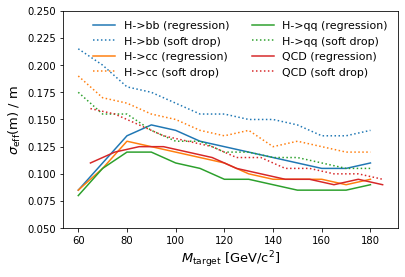

In [11]:
plt.plot(targetmasses, Hbbr, label='H->bb (regression)', c='C0')
plt.plot(targetmasses, Hbbsd, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetmasses, Hccr, label='H->cc (regression)', c='C1')
plt.plot(targetmasses, Hccsd, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetmasses, Hqqr, label='H->qq (regression)', c='C2')
plt.plot(targetmasses, Hqqsd, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetmasses+5, qcdr, label='QCD (regression)', c='C3')
plt.plot(targetmasses+5, qcdsd, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('$M_{\\rm target}$ [GeV/${\\rm c}^2$]', fontsize=13)
plt.ylabel('$\sigma_{\\rm eff}$(m) / m', fontsize=13)
plt.ylim([0.05, 0.25])
plt.show()

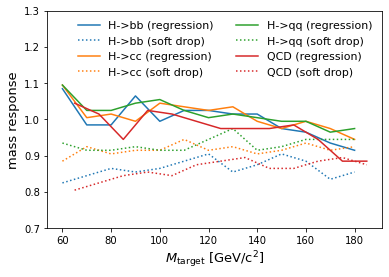

In [12]:
plt.plot(targetmasses, Hbbrm, label='H->bb (regression)', c='C0')
plt.plot(targetmasses, Hbbsdm, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetmasses, Hccrm, label='H->cc (regression)', c='C1')
plt.plot(targetmasses, Hccsdm, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetmasses, Hqqrm, label='H->qq (regression)', c='C2')
plt.plot(targetmasses, Hqqsdm, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetmasses+5, qcdrm, label='QCD (regression)', c='C3')
plt.plot(targetmasses+5, qcdsdm, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('$M_{\\rm target}$ [GeV/${\\rm c}^2$]', fontsize=13)
plt.ylabel('mass response', fontsize=13)
plt.ylim([0.7, 1.3])
plt.show()

In [11]:
# function for computing mass resolution
def getEffSigma(theHist, wmin=0.2, wmax=1.8, epsilon=0.01):

    point = wmin
    weight = 0.0
    points = []
    # number of all jets
    thesum = theHist.sum("sample", "mass").values()[()]

    # number of jets in each bin
    values = theHist.sum("sample").values()[()]

    # bin centers
    centers = theHist.to_hist().axes['mass'].centers

    # fill list of bin centers and the integral up to those points
    for i, value in enumerate(values):
        weight += value
        points.append([centers[i], weight / thesum])

    low = wmin
    high = wmax

    # loop over all possible bin combninations and find the one
    # with smallest width and ~68% of all jets
    width = wmax - wmin
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
#             print(wy)
            if abs(wy - 0.683) < epsilon:
#                 print("here")
                wx = points[j][0] - points[i][0]
#                 print(wx)
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    # print(points[j][0], points[i][0], wy, wx)
                    width = wx
    print(low, high)
    return 0.5 * (high - low)

targetpts = np.linspace(200, 2500, 47)
Hbbr = np.zeros(len(targetpts))
Hbbsd = np.zeros(len(targetpts))
Hccr = np.zeros(len(targetpts))
Hccsd = np.zeros(len(targetpts))
Hqqr = np.zeros(len(targetpts))
Hqqsd = np.zeros(len(targetpts))
qcdr = np.zeros(len(targetpts))
qcdsd = np.zeros(len(targetpts))

Hbbrm = np.zeros(len(targetpts))
Hbbsdm = np.zeros(len(targetpts))
Hccrm = np.zeros(len(targetpts))
Hccsdm = np.zeros(len(targetpts))
Hqqrm = np.zeros(len(targetpts))
Hqqsdm = np.zeros(len(targetpts))
qcdrm = np.zeros(len(targetpts))
qcdsdm = np.zeros(len(targetpts))

for i in range(len(targetpts)):
    targetpt = targetpts[i]
    
    # hbbr
    hbbrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hbbrhist.fill(sample='H->bb (regression)', 
                  mass=events.output[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_bb==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_bb==1)])

    Hbbr[i] = getEffSigma(hbbrhist)
    
    values = hbbrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hbbrhist.to_hist().axes['mass'].centers
    Hbbrm[i] = centers[index]
    
    # hbbsd
    hbbsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hbbsdhist.fill(sample='H->bb (soft drop)', 
                  mass=events.fj_msd[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_bb==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_bb==1)])

    Hbbsd[i] = getEffSigma(hbbsdhist)
    
    values = hbbsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hbbsdhist.to_hist().axes['mass'].centers
    Hbbsdm[i] = centers[index]
    
    # hccr
    hccrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hccrhist.fill(sample='H->cc (regression)', 
                  mass=events.output[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_cc==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_cc==1)])

    Hccr[i] = getEffSigma(hccrhist)
    
    values = hccrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hccrhist.to_hist().axes['mass'].centers
    Hccrm[i] = centers[index]
    
    # hccsd
    hccsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hccsdhist.fill(sample='H->cc (soft drop)', 
                  mass=events.fj_msd[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_cc==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_cc==1)])

    Hccsd[i] = getEffSigma(hccsdhist)
    
    values = hccsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hccsdhist.to_hist().axes['mass'].centers
    Hccsdm[i] = centers[index]
    
    # hqqr
    hqqrhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hqqrhist.fill(sample='H->qq (regression)', 
                  mass=events.output[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_qq==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_qq==1)])

    Hqqr[i] = getEffSigma(hqqrhist)
    
    values = hqqrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hqqrhist.to_hist().axes['mass'].centers
    Hqqrm[i] = centers[index]
    
    # hqqsd
    hqqsdhist = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hqqsdhist.fill(sample='H->qq (soft drop)', 
                  mass=events.fj_msd[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_qq==1)]/events.target_mass[((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0) & (events.label_H_qq==1)])

    Hqqsd[i] = getEffSigma(hqqsdhist)
    
    values = hqqsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = hqqsdhist.to_hist().axes['mass'].centers
    Hqqsdm[i] = centers[index]
    
    #qcdr
    qcdrhist = hist.Hist('Events',
                         hist.Cat('sample', 'sample name'),
                         hist.Bin('mass', 'Mass', 200, 0, 2),
                        )

    qcdrhist.fill(sample='QCD (regression)', 
                  mass=events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0)])
    
    qcdr[i] = getEffSigma(qcdrhist)
    
    values = qcdrhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = qcdrhist.to_hist().axes['mass'].centers
    qcdrm[i] = centers[index]
    
    #qcdsd
    qcdsdhist = hist.Hist('Events',
                         hist.Cat('sample', 'sample name'),
                         hist.Bin('mass', 'Mass', 200, 0, 2),
                        )

    qcdsdhist.fill(sample='QCD (soft drop)', 
                  mass=events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0)]/events.fj_genjet_sdmass[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_pt-targetpt) < 50) & ((events.fj_pt-targetpt) >= 0)])
    
    qcdsd[i] = getEffSigma(qcdsdhist)
    
    values = qcdsdhist.sum("sample").values()[()]
    index = np.argmax(values)
    centers = qcdsdhist.to_hist().axes['mass'].centers
    qcdsdm[i] = centers[index]

0.815 1.185
0.555 0.945
0.865 1.205
0.615 1.005
0.925 1.255
0.675 1.045
0.795 1.405
0.415 1.015
0.855 1.175
0.635 1.005
0.885 1.185
0.675 1.025
0.925 1.195
0.725 1.055
0.775 1.365
0.435 1.015
0.865 1.155
0.665 1.005
0.875 1.145
0.695 1.015
0.905 1.155
0.775 1.065
0.765 1.355
0.415 1.025
0.855 1.125
0.695 1.015
0.875 1.125
0.745 1.035
0.905 1.135
0.765 1.035
0.795 1.375
0.415 1.035
0.835 1.095
0.685 0.995
0.895 1.125
0.745 1.025
0.915 1.125
0.795 1.045
0.745 1.325
0.405 1.035
0.845 1.095
0.705 1.005
0.895 1.115
0.755 1.025
0.895 1.105
0.785 1.035
0.765 1.345
0.445 1.075
0.875 1.105
0.735 1.015
0.875 1.095
0.765 1.025
0.915 1.115
0.795 1.035
0.725 1.295
0.465 1.105
0.885 1.105
0.715 1.005
0.895 1.105
0.785 1.035
0.905 1.105
0.825 1.055
0.745 1.305
0.415 1.045
0.875 1.095
0.755 1.035
0.895 1.095
0.775 1.025
0.915 1.105
0.815 1.045
0.715 1.275
0.385 1.035
0.875 1.095
0.735 1.025
0.915 1.105
0.785 1.035
0.915 1.105
0.815 1.055
0.765 1.325
0.395 1.075
0.875 1.105
0.735 1.045
0.915 1.115
0.78

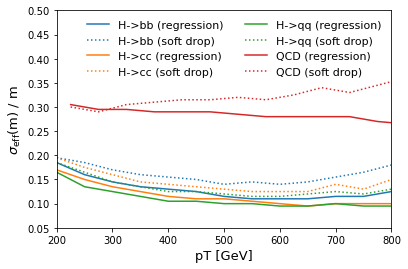

In [35]:
plt.plot(targetpts, Hbbr, label='H->bb (regression)', c='C0')
plt.plot(targetpts, Hbbsd, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetpts, Hccr, label='H->cc (regression)', c='C1')
plt.plot(targetpts, Hccsd, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetpts, Hqqr, label='H->qq (regression)', c='C2')
plt.plot(targetpts, Hqqsd, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetpts+25, qcdr, label='QCD (regression)', c='C3')
plt.plot(targetpts+25, qcdsd, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('pT [GeV]', fontsize=13)
plt.ylabel('$\sigma_{\\rm eff}$(m) / m', fontsize=13)
plt.ylim([0.05, 0.5])
plt.xlim([200, 800])
plt.show()

In [36]:
Hbbre = np.zeros(len(targetpts))
Hbbsde = np.zeros(len(targetpts))
Hccre = np.zeros(len(targetpts))
Hccsde = np.zeros(len(targetpts))
Hqqre = np.zeros(len(targetpts))
Hqqsde = np.zeros(len(targetpts))
qcdre = np.zeros(len(targetpts))
qcdsde = np.zeros(len(targetpts))

for i in range(len(targetpts)):
    # hbbr
    sigma_eff = Hbbr[i]
    MPV = Hbbrm[i]

    jets = len(events.output[(events.label_H_bb==1) & ((events.output/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.output/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hbbre[i]=jets/len(events.output[events.label_H_bb==1])
    
    # hbbsd
    sigma_eff = Hbbsd[i]
    MPV = Hbbsdm[i]

    jets = len(events.fj_msd[(events.label_H_bb==1) & ((events.fj_msd/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.fj_msd/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hbbsde[i]=jets/len(events.fj_msd[events.label_H_bb==1])
    
    # hccr
    sigma_eff = Hccr[i]
    MPV = Hccrm[i]

    jets = len(events.output[(events.label_H_cc==1) & ((events.output/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.output/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hccre[i]=jets/len(events.output[events.label_H_cc==1])
    
    # hccsd
    sigma_eff = Hccsd[i]
    MPV = Hccsdm[i]

    jets = len(events.fj_msd[(events.label_H_cc==1) & ((events.fj_msd/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.fj_msd/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hccsde[i]=jets/len(events.fj_msd[events.label_H_cc==1])
    
    # hqqr
    sigma_eff = Hqqr[i]
    MPV = Hqqrm[i]

    jets = len(events.output[(events.label_H_qq==1) & ((events.output/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.output/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hqqre[i]=jets/len(events.output[events.label_H_qq==1])
    
    # hqqsd
    sigma_eff = Hqqsd[i]
    MPV = Hqqsdm[i]

    jets = len(events.fj_msd[(events.label_H_qq==1) & ((events.fj_msd/events.target_mass) > (MPV - 2 * sigma_eff)) & ((events.fj_msd/events.target_mass) < (MPV + 2 * sigma_eff))])
    Hqqsde[i]=jets/len(events.fj_msd[events.label_H_qq==1])
    
    # qcdr
    sigma_eff = qcdr[i]
    MPV = qcdrm[i]

    jets = len(events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.output/events.fj_genjet_sdmass) > (MPV - 2 * sigma_eff)) & ((events.output/events.fj_genjet_sdmass) < (MPV + 2 * sigma_eff))])
    qcdre[i]=jets/len(events.output[(events.sample_isQCD==1) & (events.label_QCD_all==1)])
    
    # qcdsd
    sigma_eff = qcdsd[i]
    MPV = qcdsdm[i]

    jets = len(events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1) & ((events.fj_msd/events.fj_genjet_sdmass) > (MPV - 2 * sigma_eff)) & ((events.fj_msd/events.fj_genjet_sdmass) < (MPV + 2 * sigma_eff))])
    qcdsde[i]=jets/len(events.fj_msd[(events.sample_isQCD==1) & (events.label_QCD_all==1)])


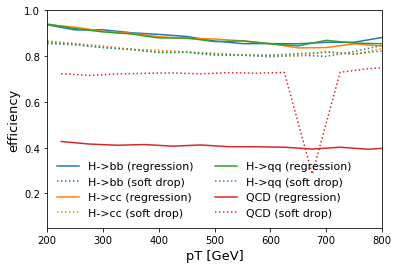

In [37]:
plt.plot(targetpts, Hbbre, label='H->bb (regression)', c='C0')
plt.plot(targetpts, Hbbsde, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetpts, Hccre, label='H->cc (regression)', c='C1')
plt.plot(targetpts, Hccsde, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetpts, Hqqre, label='H->qq (regression)', c='C2')
plt.plot(targetpts, Hqqsde, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetpts+25, qcdre, label='QCD (regression)', c='C3')
plt.plot(targetpts+25, qcdsde, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('pT [GeV]', fontsize=13)
plt.ylabel('efficiency', fontsize=13)
plt.ylim([0.05, 1])
plt.xlim([200, 800])
plt.show()

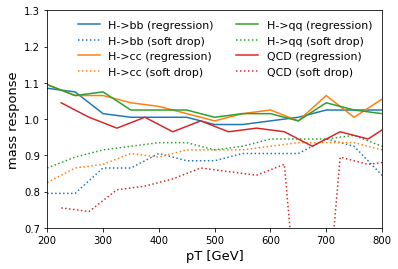

In [12]:
plt.plot(targetpts, Hbbrm, label='H->bb (regression)', c='C0')
plt.plot(targetpts, Hbbsdm, label='H->bb (soft drop)', c='C0', ls=':')
plt.plot(targetpts, Hccrm, label='H->cc (regression)', c='C1')
plt.plot(targetpts, Hccsdm, label='H->cc (soft drop)', c='C1', ls=':')
plt.plot(targetpts, Hqqrm, label='H->qq (regression)', c='C2')
plt.plot(targetpts, Hqqsdm, label='H->qq (soft drop)', c='C2', ls=':')
plt.plot(targetpts+25, qcdrm, label='QCD (regression)', c='C3')
plt.plot(targetpts+25, qcdsdm, label='QCD (soft drop)', c='C3', ls=':')
plt.legend(fontsize=11, frameon=False, ncol=2)
plt.xlabel('pT [GeV]', fontsize=13)
plt.ylabel('mass response', fontsize=13)
plt.ylim([0.7, 1.3])
plt.xlim([200, 800])
plt.show()